# Study Case: BBC News

In this python notebook it will be studied a BBC news dataset and analyzed with DimCuantifier to estimate complexity of all news. For now on news will be treated as documents, and the number of dimensions estimated with DimCunatifier will be called complexity. 

The focus of interest in this notebook is correlation between bias, intensity (As described in FrameAxis framework paper) and principal components of the PCA performed on corpus represented with polar embeddings

In [4]:
# Import
from DimCuantifier import DimCuantifier
from PreProcessingDimCuantifier import PreProcessingDimCuantifier

import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Set Model

First, set word embeddings model, in this case normalized Glove with 42 billions of words and 300 dimensions

In [3]:
# normalized glove embeddings
norm_glove_42B = 'normalized_glove.42B.300d.mod'

current_model = gensim.models.KeyedVectors.load_word2vec_format(
    norm_glove_42B, binary=True)

## Set Polar Words list

Set list of pairs of polar words to use as semantic axis (list of words obtained from Polar framework repository) 

In [2]:
PreProcess = PreProcessingDimCuantifier()

In [4]:
filenames_list = ['..\Antonym_sets\LenciBenotto.val',
                  '..\Antonym_sets\LenciBenotto.test',
                  '..\Antonym_sets\EVALution.val',
                  '..\Antonym_sets\EVALution.test']

# Extract polar pairs from files
list_polar_pairs = PreProcess.list_polar_words_tuple(
    filenames_list, current_model)

# Select most different polar pairs when there is repetition of words
final_polar_pairs_list = PreProcess.select_polar_words_list(
    current_model, list_polar_pairs)

# Print a sample of final polar pairs
final_polar_pairs_list[0:5]

[('exclude', 'inscribe'),
 ('assertion', 'meek'),
 ('beginning', 'terminal'),
 ('lop', 'secure'),
 ('libertine', 'pastor')]

## Load Dataset

Load dataset already tokenized in pickle format

In [5]:
filename = 'bbc_news_dataset_tokenized.pkl'
bbc_news_dataset = pd.read_pickle(filename)
bbc_news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   category           2225 non-null   category
 1   title              2225 non-null   object  
 2   content            2225 non-null   object  
 3   content_tokenized  2225 non-null   object  
 4   original_len       2225 non-null   int16   
 5   tokenized_len      2225 non-null   int16   
dtypes: category(1), int16(2), object(3)
memory usage: 63.2+ KB


Just as previous notebook, reduce lenght and select around the mean (or median) to have documents similar in lenght enough to compare

In [6]:
mean_tokenized_len = int(bbc_news_dataset['tokenized_len'].mean())
mean_tokenized_len

229

In [7]:
# Reduce lenght of larger documents to the mean length
bbc_news_dataset['content_tokenized_reduced'] = bbc_news_dataset['content_tokenized'].apply(
    lambda x: x if len(x) < mean_tokenized_len else x[:mean_tokenized_len])
bbc_news_dataset['tokenized_len_reduced'] = bbc_news_dataset['content_tokenized_reduced'].apply(lambda x: len(x))

In [9]:
# Select documents with length around the mean
corpus_filtered_reduced_and_selected_around_mean = bbc_news_dataset.loc[
    bbc_news_dataset['tokenized_len_reduced'] <= mean_tokenized_len + mean_tokenized_len * 0.1]
corpus_filtered_reduced_and_selected_around_mean = corpus_filtered_reduced_and_selected_around_mean.loc[
    bbc_news_dataset['tokenized_len_reduced'] >= mean_tokenized_len - mean_tokenized_len * 0.1]

print(f'Number of document kept: {corpus_filtered_reduced_and_selected_around_mean.shape[0]}')

Number of document kept: 1073


## Bias and Intensity correlation
Calculate bias and intensity, for that is needed to set corpus to a DimCuantifier object 

In [9]:
# Define corpus
corpus_selected_and_reduced = list(corpus_filtered_reduced_and_selected_around_mean['content_tokenized_reduced'])

# Create Object
DC = DimCuantifier(current_model, final_polar_pairs_list)

# Set Corpus to DimCuantifier
DC.set_corpus(corpus_selected_and_reduced)

Calculate bias and intensity of the corpus for every polar pair. This will be used to compare correlation with other results

In [10]:
bias_intensity_df = DC.calculate_bias_and_intensity()

,polar_pairs,bias,intensity
116,"(emasculate, help)",-0.331582,0.021974
296,"(disadvantageous, good)",-0.302916,0.020390
795,"(keep_alive, kill)",-0.308957,0.020183
262,"(antimatter, matter)",-0.308467,0.018622
45,"(typical, untypical)",0.311790,0.018510
...,...,...,...
1372,"(gum, tooth)",-0.033743,0.001994
463,"(nasal, uterine)",0.034711,0.001927
453,"(germ, iodine)",0.014740,0.001926
1165,"(snow, sun)",-0.009248,0.001874


## Calculate Loading Scores

Cuantify complexity and then calculate loading scores. Loading scores gives information of all the principal components and are related to its original semantic axis that represent a polar dimension. It also adds a column of the sum for principal component values (the absolute values) and a column for a weighted sum (weighted by the percentage of variance that represents)

In [14]:
DC.cuantify_dim(on='corpus', embedding='polar')
DC.calculate_loading_scores(on='corpus')

Get loadings scores dataframe and add bias and intensity in the same order that semantic axis were given

In [17]:
loading_scores = DC.get_loading_scores(on='corpus').copy()
loading_scores['bias'] = bias_intensity_df['bias'].values
loading_scores['intensity'] = bias_intensity_df['intensity'].values
loading_scores

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_236,PC_237,PC_238,PC_239,PC_240,PC_241,weighted_sum,sum,bias,intensity
"(exclude, inscribe)",-0.042622,-0.019440,0.038859,0.015893,0.001061,-0.009620,-0.011686,0.032437,0.003777,-0.003017,...,-0.006268,0.017286,-0.010173,0.048273,-0.030351,0.073412,0.020961,4.937530,-0.331582,0.021974
"(assertion, meek)",-0.014171,-0.038162,0.026993,0.049635,-0.035398,0.024935,-0.031006,0.014103,-0.005865,-0.001016,...,0.023400,0.040835,0.032527,-0.003306,-0.019038,-0.000417,0.021241,4.856154,-0.302916,0.020390
"(beginning, terminal)",-0.004434,-0.013643,0.008867,-0.033748,-0.058274,-0.026529,-0.008967,0.037504,-0.050930,-0.037094,...,-0.007755,0.000113,-0.012669,-0.037115,0.005030,0.014189,0.020720,4.536245,-0.308957,0.020183
"(lop, secure)",-0.039115,-0.011590,0.004374,-0.048499,-0.015326,0.009176,0.008509,0.012680,-0.002335,0.041225,...,-0.044290,-0.006395,-0.051894,-0.043815,-0.019643,0.021418,0.020353,4.375504,-0.308467,0.018622
"(libertine, pastor)",-0.012145,0.016478,-0.042774,-0.003880,-0.001374,-0.015218,0.034179,0.032420,0.008245,-0.007433,...,0.029642,-0.036498,0.027686,-0.008495,0.036137,-0.007813,0.020854,5.218661,0.311790,0.018510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(doctor, patient)",-0.021869,-0.012030,-0.045702,-0.017919,0.047781,-0.026407,0.002675,0.010298,-0.017132,0.016142,...,0.027598,-0.020893,-0.000385,0.005236,0.040723,0.024306,0.021617,4.878693,-0.033743,0.001994
"(god, mortal)",-0.018598,-0.000798,-0.002777,0.022409,-0.011955,0.017675,-0.006046,-0.006812,0.030381,-0.067215,...,-0.058278,-0.008460,-0.008192,-0.010702,-0.042117,0.000019,0.019454,5.498024,0.034711,0.001927
"(china, japan)",-0.003315,-0.031634,0.017089,0.017954,0.047636,-0.008425,-0.011431,-0.005368,0.039739,-0.035115,...,0.033840,0.004158,0.001063,-0.002108,-0.000774,-0.019414,0.020734,4.498508,0.014740,0.001926
"(fasten, loose)",-0.016361,0.007519,0.010069,-0.037019,0.028554,0.022074,0.029208,-0.011145,0.010315,-0.030873,...,-0.019883,-0.011266,0.064366,-0.001912,-0.054847,-0.001936,0.021358,5.991863,-0.009248,0.001874


Since the first principal components have more variation, let's select the first three and sum, weighted sum, bias and intensity

In [19]:
loading_scores_filtered = loading_scores[['PC_1', 'PC_2', 'PC_3', 'weighted_sum', 'sum', 'bias', 'intensity']]
loading_scores_filtered

,PC_1,PC_2,PC_3,weighted_sum,sum,bias,intensity
"(exclude, inscribe)",-0.042622,-0.019440,0.038859,0.020961,4.937530,-0.331582,0.021974
"(assertion, meek)",-0.014171,-0.038162,0.026993,0.021241,4.856154,-0.302916,0.020390
"(beginning, terminal)",-0.004434,-0.013643,0.008867,0.020720,4.536245,-0.308957,0.020183
"(lop, secure)",-0.039115,-0.011590,0.004374,0.020353,4.375504,-0.308467,0.018622
"(libertine, pastor)",-0.012145,0.016478,-0.042774,0.020854,5.218661,0.311790,0.018510
...,...,...,...,...,...,...,...
"(doctor, patient)",-0.021869,-0.012030,-0.045702,0.021617,4.878693,-0.033743,0.001994
"(god, mortal)",-0.018598,-0.000798,-0.002777,0.019454,5.498024,0.034711,0.001927
"(china, japan)",-0.003315,-0.031634,0.017089,0.020734,4.498508,0.014740,0.001926
"(fasten, loose)",-0.016361,0.007519,0.010069,0.021358,5.991863,-0.009248,0.001874


See correlation between the already selected columns

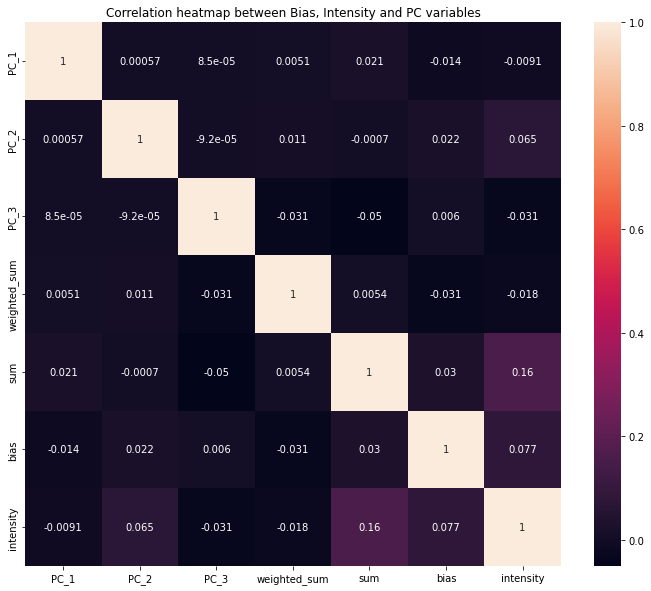

In [20]:
corr_df = loading_scores_filtered.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True)
plt.title('Correlation heatmap between Bias, Intensity and PC variables')
plt.show()

# Conclusion

- Bias and intensity does not seem to have a significant correlation in general with principal components
- Most significant correlation is between sum of principal component absolute values and intensity with 16%